<div style="background: #1e2761; color: white; padding: 10px; font-size: 18pt">
<b><center>Определение перспективного тарифа для телеком компании<b>
    
</div> 

<font size="5">Оглавление</font>

[Описание задачи](#description)  
[Импорты и настройки](#imports)

[Шаг 1. Изучение общей информации](#start)  
* [1.1 Звонки](#calls)
* [1.2 Интернет](#internet)
* [1.3 СМС](#messages)
* [1.4 Тарифы](#tariffs)
* [1.5 Пользователи](#users)  

[Вывод по шагу 1](#start_conclusion)

[Шаг 2. Предобработка данных](#preprocessing)  
* [2.1 Обработка аномальных значений](#illogic)
* [2.2 Округление значений](#round)
* [2.3 Приведение типов](#types)
* [2.4 Добавление расчетных данных](#adding_data)  

[Вывод по шагу 2](#preprocessing_conclusion)

[Шаг 3. Анализ поведения клиентов](#analysis)  
[Вывод по шагу 3](#analysis_conclusion)

[Шаг 4. Проверка гипотез](#tests)
* [4.1 Различия в средней выручке по тарифам](#tests_income_tarif)
* [4.2 Различия в средней выручке по регионам](#tests_income_location)

[Вывод по шагу 4](#tests_conclusion)

[Общий вывод](#total_conclusion)

------

<a id='description'></a>
## Описание задачи


«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<a id='imports'></a>
### Импорты и настройки

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)

<a id='start'></a>
## Шаг 1. Изучение общей информации

In [3]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [4]:
def first_look(df):
    display(df.info())
    display(df.head(5))
    display(df.describe())

<a id='calls'></a>
### 1.1 Звонки

In [5]:
first_look(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,duration,user_id
count,202607.00,202607.00
mean,6.76,1253.94
std,5.84,144.72
min,0.00,1000.00
25%,1.30,1126.00
50%,6.00,1260.00
75%,10.70,1379.00
max,38.00,1499.00


Таблица со звонками содержит информацию в разрезе каждого звонка (по ключу `id`) - дату, продолжительность и `id` клиента. Пропусков в столбцах нет. Данные столбца `call_date` нужно в явном виде привести к `datetime`, чтобы иметь возможность работать с ними как с датой.

Минимальное значение продолжительности разговора составляет 0 минут, возможно, это входящие или пропущенные звонки, после дополнительного анализа примем решение о необходимости присутствия их в датафрейме.

Количество минут в таблице представлено в виде дробных чисел, тарификация же производится по значениям, округленным до целого количества минут, для корректного начисления сумм необходимо округлить вверх значения длительности разговоров.

In [6]:
len(calls[calls['duration'] == 0])

39613

Text(0.5, 0, 'Длительность звонка, мин.')

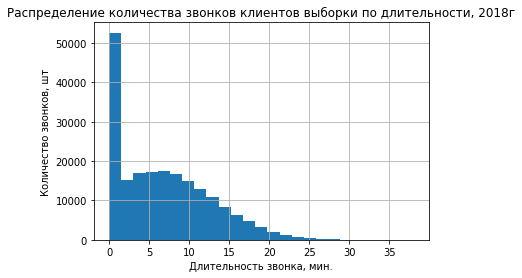

In [7]:
calls['duration'].hist(bins=25)
plt.title('Распределение количества звонков клиентов выборки по длительности, 2018г')
plt.ylabel('Количество звонков, шт')
plt.xlabel('Длительность звонка, мин.')

Как и было обнаружено, большое количество звонков в районе 0 выглядят как выброс, без них распределение будет похоже на нормальное. Остановимся на предположении, что это пропущенные или не отвеченные вызовы, для целей анализа они не представляют ценности, т.к. не могут быть протарифицированы, поэтому удалим строки с длительностью вызовов равным 0. 

<a id='internet'></a>
### 1.2 Интернет

In [8]:
first_look(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,Unnamed: 0,mb_used,user_id
count,149396.00,149396.00,149396.00
mean,74697.50,370.19,1252.10
std,43127.05,278.30,144.05
min,0.00,0.00,1000.00
25%,37348.75,138.19,1130.00
50%,74697.50,348.01,1251.00
75%,112046.25,559.55,1380.00
max,149395.00,1724.83,1499.00


Таблица с интернет траффиком содержит информацию в разрезе каждого подключения (по ключу `id`) - дата, потраченные Мб, `id` клиента. Пропусков в данных нет, столбец `session_date` приведем к формату `datetime`. Столбец `Unnamed: 0` не содержит ценной информации, дублирует столбец с индексами, поэтому удалим его.

Минимальное значение потраченных Мб составляет 0, после дополнительного анализа примем решение о необходимости присутствия этих данных в датафрейме.

Аналогично минутам количество потраченных Мб в таблице представлено в виде дробных чисел, для корректного начисления сумм в дальнейшем, необходимо округлить вверх значения интернет-траффика.

In [9]:
len(internet[internet['mb_used'] == 0])

19598

Text(0.5, 0, 'Траффик, Мб.')

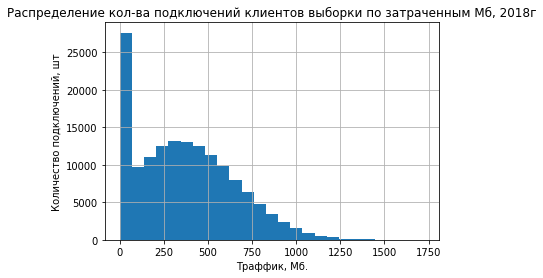

In [10]:
internet['mb_used'].hist(bins=25)
plt.title('Распределение кол-ва подключений клиентов выборки по затраченным Мб, 2018г')
plt.ylabel('Количество подключений, шт')
plt.xlabel('Траффик, Мб.')

Аналогично звонкам большое количество подключений с нулевым траффиком выглядят аномальными, без них распределение будет похоже на нормальное. Т.к. нулевые подключения не могут быть протарифицированы, удалим эти строки из выборки.

<a id='messages'></a>
### 1.3 СМС

In [11]:
first_look(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,user_id
count,123036.00
mean,1256.99
std,143.52
min,1000.00
25%,1134.00
50%,1271.00
75%,1381.00
max,1499.00


Таблица с данными по СМС содержит информацию в разрезе каждого сообщени (по ключу `id`) - дату сообщения и `id` клинета. Пропусков в данных нет, столбец `message_date` нужно привести к формату `datetime`.

<a id='tariffs'></a>
### 1.4 Тарифы

In [12]:
first_look(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.00,2.00,2.00,2.00,2.00,2.00,2.00
mean,525.00,23040.00,1750.00,1250.00,175.00,2.00,2.00
std,671.75,10861.16,1767.77,989.95,35.36,1.41,1.41
min,50.00,15360.00,500.00,550.00,150.00,1.00,1.00
25%,287.50,19200.00,1125.00,900.00,162.50,1.50,1.50
50%,525.00,23040.00,1750.00,1250.00,175.00,2.00,2.00
75%,762.50,26880.00,2375.00,1600.00,187.50,2.50,2.50
max,1000.00,30720.00,3000.00,1950.00,200.00,3.00,3.00


Таблица с тарифами состоит из 2 строк, каждая из которых содержит информацию по одному из анализируемых тарифов - "smart"  и "ultra". В информацию о тарифах включено: объемы минут, интернет-траффика и смс, покрываемые абонентской платой, размер абонентской платы, а также стоимость тарификации минут, интернет-траффика и смс свыше лимита. Информация в таблице корректна и соответствует предоставленному словесному описанию тарифов.

<a id='users'></a>
### 1.5 Пользователи

In [13]:
first_look(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,user_id,age
count,500.00,500.00
mean,1249.50,46.59
std,144.48,16.67
min,1000.00,18.00
25%,1124.75,32.00
50%,1249.50,46.00
75%,1374.25,62.00
max,1499.00,75.00


Таблица с информацией о 500 пользователях представлена в разрезе уникальных `id` клиентов. В 7 из 8 столбцов присутствуют все данные. В колонке с датой прекращения действия тарифа (`churn_date`) заполнено 38 значений, значит, у остальных пользователей тариф действующий. Данные в столбцах `reg_date` и `churn_date` необходимо привести к формату `datetime`.

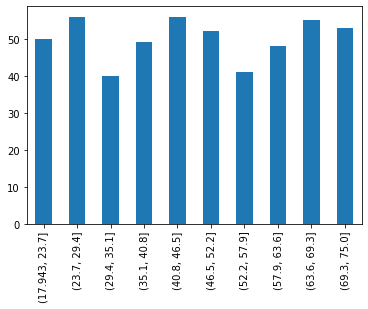

In [14]:
pd.cut(users['age'], 10).value_counts().sort_index().plot(kind='bar')

Группы клиентов по возрасту представлены достаточно равномерно

In [15]:
users[users['churn_date'].notna()].groupby('tariff')['user_id'].count()

tariff
smart    23
ultra    15
Name: user_id, dtype: int64

Клиенты прекращают пользоваться как одним, так и другим тарифом, мы не можем сделать предположения о заведомо неинтересном тарифе для клиентов.

In [16]:
users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Место проживания пользователей унифицированы и не содержат некорректных записей

smart    351
ultra    149
Name: tariff, dtype: int64

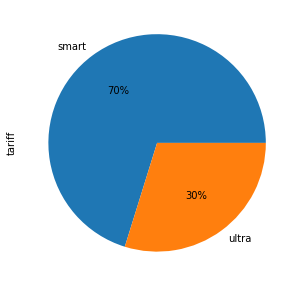

In [17]:
users['tariff'].value_counts().plot(kind='pie', autopct='%1.f%%', figsize=(7,5))
users['tariff'].value_counts()

Подавляющее большинство клиентов выборки (70%) предпочли тариф "smart" (и, вероятно, чувствовали себя весьма smart при этом), проанализируем в дальнейшем насколько этот выбор соответствует стратегии компании, стремящейся к увеличению своего дохода.

<a id='start_conclusion'></a>
## Вывод по шагу 1

Полученные данные довольно "чистые" и нуждаются в минимальной предобработке:  
1. Для удобства дальнейшего анализа обработаем аномальные значения, т.е. удалим строки с нулевыми значениями потраченных минут и интернет-траффика в соответствующих таблицах. Удалим `Unnamed: 0` столбец таблицы `internet`. 
2. Для корректной тарификации и расчета выручки необходимо округлить вверх значения потраченных минут и интернет-траффика в разрезе каждой операции.
3. Для возможности работы с датами необходимо привести соответствующие столбцы в таблицах к формату `datetime`.

<a id='preprocessing'></a>
## Шаг 2. Предобработка данных

<a id='illogic'></a>
### Шаг 2.1 Обработка аномальных значений

Удалим звонки с нулевой длительностью (39613 шт) - вероятно, это входящие звонки или пропущенные, в любом случае их невозможно протарифицировать, в противном случае они будут бесполезно увеличивать объем данных в выборке и влиять на среднее количество звонков.

In [18]:
calls_new = calls.drop(calls.loc[calls['duration'] == 0].index)
calls_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
id           162994 non-null object
call_date    162994 non-null object
duration     162994 non-null float64
user_id      162994 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Удалим строки с нулевым траффиком (19598 шт), аналогично звонкам, они не смогут быть протарифицированы, но будут влиять на объем данных и статистику количества подключений. Также удалим столбец unnamed, т.к. он повторяет столбец с индексами

In [19]:
internet_new = internet.drop(internet[internet['mb_used'] == 0].index)
del(internet_new['Unnamed: 0'])
internet_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 4 columns):
id              129798 non-null object
mb_used         129798 non-null float64
session_date    129798 non-null object
user_id         129798 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.0+ MB


<a id='round'></a>
### Шаг 2.2 Округление значений

«Мегалайн» всегда округляет вверх значения минут и мегабайтов, значит, для корректного дальнейшего расчета стоимости необходимо провести округление каждого из звонков и каждого из подключений к интернету, используем соответствующую функцию `ceil()`

In [20]:
calls_new['duration_ceil'] = calls_new['duration'].apply('ceil')

In [21]:
internet_new['mb_used_ceil'] = internet_new['mb_used'].apply('ceil')

<a id='types'></a>
### Шаг 2.3 Приведение типов

Переименуем столбцы с датой в каждой из таблиц и дадим унифицированное название `date`, затем приведем данные к типу `datetime`

In [22]:
calls_new.rename({'call_date' : 'date'}, axis=1, inplace=True)
internet_new.rename({'session_date' : 'date'}, axis=1, inplace=True)
messages.rename({'message_date' : 'date'}, axis=1, inplace=True)

In [23]:
frames = [calls_new, internet_new, messages]
for df in frames:
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

<a id='adding_data'></a>
### Шаг 2.4 Добавление расчетных данных

Детализированные до операций данные позволили нам округлить информацию по минутам и Мб, для дальнейшего анализа агрегируем операции по месяцам, т.к. абонентская плата и превышения лимитов рассчитываются в рамках календарного месяца.

In [24]:
for df in frames:
    df['month'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.month

In [25]:
calls_by_month = calls_new.groupby(['month', 'user_id']).agg({'duration_ceil' : ['count', 'sum']}).reset_index()
calls_by_month.set_axis(['month', 'user_id', 'duration_count', 'duration_sum'], axis=1, inplace=True)
calls_by_month.head()

,month,user_id,duration_count,duration_sum
0,1,1005,11,95.00
1,1,1032,44,380.00
2,1,1045,1,9.00
3,1,1055,47,551.00
4,1,1071,18,194.00


In [26]:
calls_by_month.describe()

,month,user_id,duration_count,duration_sum
count,3168.00,3168.00,3168.00,3168.00
mean,8.32,1251.48,51.45,457.80
std,2.91,144.57,26.44,237.42
min,1.00,1000.00,1.00,1.00
25%,6.00,1126.00,33.00,290.75
50%,9.00,1254.00,50.00,447.50
75%,11.00,1379.00,67.00,592.25
max,12.00,1499.00,190.00,1673.00


In [27]:
# проверка кол-во звонков тотал
calls_by_month['duration_count'].sum()

162994

In [28]:
internet_by_month = internet_new.groupby(['month', 'user_id']).agg({'mb_used_ceil' : ['count', 'sum']}).reset_index()
internet_by_month.set_axis(['month', 'user_id', 'mb_used_count', 'mb_used_sum'], axis=1, inplace=True)
internet_by_month.describe()

,month,user_id,mb_used_count,mb_used_sum
count,3201.00,3201.00,3201.00,3201.00
mean,8.32,1251.41,40.55,17297.55
std,2.90,144.83,16.15,7513.50
min,1.00,1000.00,1.00,202.00
25%,6.00,1124.00,30.00,12567.00
50%,9.00,1251.00,41.00,16986.00
75%,11.00,1379.00,51.00,21458.00
max,12.00,1499.00,101.00,49789.00


In [29]:
# проверка сумма по количеству Mb
internet_by_month['mb_used_count'].sum()

129798

In [30]:
messages_by_month = messages.groupby(['month', 'user_id'])['id'].count()

In [31]:
messages_by_month = messages_by_month.reset_index()
messages_by_month.rename({'id' : 'messages_count'}, axis=1, inplace=True)

In [32]:
messages_by_month.head()

,month,user_id,messages_count
0,1,1005,7
1,1,1032,38
2,1,1045,5
3,1,1055,30
4,1,1071,16


In [33]:
messages_by_month.describe()

,month,user_id,messages_count
count,2717.00,2717.00,2717.00
mean,8.35,1255.64,45.28
std,2.89,146.23,35.05
min,1.00,1000.00,1.00
25%,6.00,1126.00,19.00
50%,9.00,1266.00,38.00
75%,11.00,1384.00,63.00
max,12.00,1499.00,224.00


In [34]:
# проверка суммарное кол-во смс
messages_by_month.sum()

month               22674
user_id           3411561
messages_count     123036
dtype: int64

Соберем свод из таблиц со звонками, траффиком и смс, сгруппированных по клиентам и месяцам:
* calls_by_month
* internet_by_month
* messages_by_month

In [35]:
df = pd.merge(left = calls_by_month, right = internet_by_month, how = 'outer', on = ['user_id', 'month'])
df = pd.merge(left = df, right = messages_by_month, how = 'outer', on = ['user_id', 'month'])

In [36]:
df.describe()

,month,user_id,duration_count,duration_sum,mb_used_count,mb_used_sum,messages_count
count,3214.00,3214.00,3168.00,3168.00,3201.00,3201.00,2717.00
mean,8.32,1251.59,51.45,457.80,40.55,17297.55,45.28
std,2.91,144.66,26.44,237.42,16.15,7513.50,35.05
min,1.00,1000.00,1.00,1.00,1.00,202.00,1.00
25%,6.00,1125.00,33.00,290.75,30.00,12567.00,19.00
50%,9.00,1253.00,50.00,447.50,41.00,16986.00,38.00
75%,11.00,1378.75,67.00,592.25,51.00,21458.00,63.00
max,12.00,1499.00,190.00,1673.00,101.00,49789.00,224.00


Добавим информацию по каждому клиенту из таблицы `users`, интересующие в рамках текущего анализа столбцы - тариф и город клиента.

In [37]:
df = pd.merge(left = df, right = users, how = 'outer', on = 'user_id')

Добавим в таблицу данные по тарифам для подсчета выручки с каждого пользователя

In [38]:
df = pd.merge(left = df, right = tariffs, how = 'outer', left_on = 'tariff', right_on = 'tariff_name')
del(df['tariff_name'])

Добавим расчетные столбцы с превышением лимитов фактических расходов минут, траффика и СМС

In [39]:
df['duration_delta'] = np.where(df['duration_sum'] > df['minutes_included'],\
                                df['duration_sum'] - df['minutes_included'], 0)
df['messages_delta'] = np.where(df['messages_count'] > df['messages_included'],\
                                df['messages_count'] - df['messages_included'], 0)
df['gb_used_delta'] = np.where(df['mb_used_sum'] > df['mb_per_month_included'],\
                               np.ceil( (df['mb_used_sum'] - df['mb_per_month_included'])/1024), 0)

Добавим расчетный столбец `income` с итого выручкой по клиенту за конкретный месяц

In [40]:
df['income'] = df['duration_delta'] * df['rub_per_minute']\
            + df['messages_delta'] * df['rub_per_message']\
            + df['gb_used_delta'] * df['rub_per_gb']\
            + df['rub_monthly_fee']

In [41]:
# проверка итого выручка
df['income'].sum()

4928251.0

<a id='preprocessing_conclusion'></a>
## Вывод по шагу 2

Для возможности проведения анализа была сделана предобработка данных:
1. Удалены строки с нулевыми значениями потраченных минут и интернет-траффика
2. Округлены вверх значения потраченных минут и интернет-траффика в разрезе каждой операции.
3. Приведены соответствующие столбцы дат в таблицах к формату `datetime`, выделены месяца операций

Данные были укрупнены и агрегированы по месяцам. По ключу "клиент-месяц" информация была собрана в единую таблицу `df`. Были добавлены расчетные столбцы превышения лимитов фактическими расходами, проведена тарификация и рассчитана общая выручка по каждому клиенту в месяц (столбец `income`). 

In [61]:
df.head(3)

,month,user_id,duration_count,duration_sum,mb_used_count,mb_used_sum,messages_count,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,duration_delta,messages_delta,gb_used_delta,income
0,1.00,1005,11.00,95.00,6.00,2730.00,7.00,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3,0.00,0.00,0.00,550.00
1,2.00,1005,55.00,456.00,22.00,7394.00,38.00,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3,0.00,0.00,0.00,550.00
2,3.00,1005,63.00,606.00,25.00,11117.00,56.00,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3,106.00,6.00,0.00,886.00


<a id='analysis'></a>
## Шаг 3. Анализ поведения клиентов

Исходя из таблицы `df`, содержащей все необходимые столбцы, сравним статистики двух тарифов

In [43]:
df = df.drop(df[df['month'].isna()].index)

In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
month,3214.00,8.32,2.91,1.00,6.00,9.00,11.00,12.00
user_id,3214.00,1251.59,144.66,1000.00,1125.00,1253.00,1378.75,1499.00
duration_count,3168.00,51.45,26.44,1.00,33.00,50.00,67.00,190.00
duration_sum,3168.00,457.80,237.42,1.00,290.75,447.50,592.25,1673.00
mb_used_count,3201.00,40.55,16.15,1.00,30.00,41.00,51.00,101.00
mb_used_sum,3201.00,17297.55,7513.50,202.00,12567.00,16986.00,21458.00,49789.00
messages_count,2717.00,45.28,35.05,1.00,19.00,38.00,63.00,224.00
age,3214.00,46.64,16.59,18.00,32.00,46.00,62.00,75.00
messages_included,3214.00,341.15,438.04,50.00,50.00,50.00,1000.00,1000.00
mb_per_month_included,3214.00,20067.41,7082.49,15360.00,15360.00,15360.00,30720.00,30720.00


In [45]:
df.groupby('tariff').agg({'duration_sum' : ['sum', 'mean'],\
                          'mb_used_sum' : ['sum', 'mean'],\
                          'messages_count' : ['sum', 'mean'],\
                         'income' : ['sum', 'mean']})

duration_sum        mb_used_sum          messages_count        \
                sum   mean         sum     mean            sum  mean   
tariff                                                                 
smart     931577.00 419.44 36174861.00 16243.76       74413.00 38.72   
ultra     518724.00 547.76 19194598.00 19706.98       48623.00 61.16   

           income          
              sum    mean  
tariff                     
smart  2885751.00 1294.64  
ultra  2040000.00 2071.07

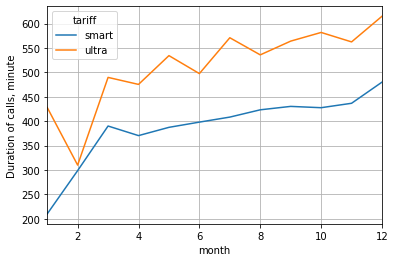

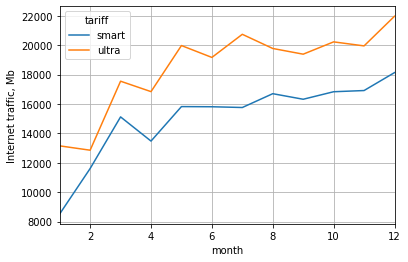

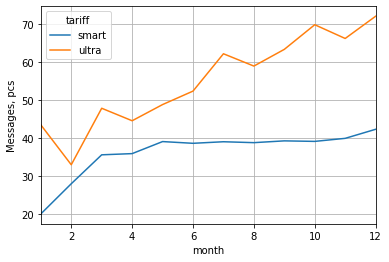

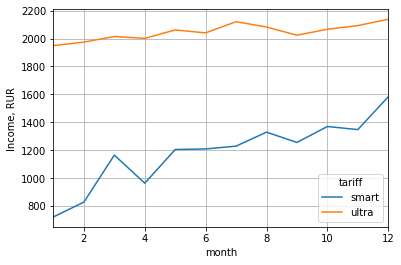

In [46]:
columns = ['duration_sum', 'mb_used_sum', 'messages_count', 'income']
dimension = {'duration_sum' : 'Duration of calls, minute', 'mb_used_sum' : 'Internet traffic, Mb',\
       'messages_count' : 'Messages, pcs', 'income' : 'Income, RUR'}

for col in columns:
    df.pivot_table(index='month', columns='tariff', values=col).plot(grid=True)
    plt.ylabel('{}'.format(dimension.get(col)))

Как было отмечено ранее, тариф "smart" пользуется большей популярностью, абсолютные значения затрат по минутам, траффику и СМС и абсолютные значения дохода по нашей выборке действительно выше, чем в целом по тарифу "ultra". Но при этом анализируя средние показатели видим обратную ситуацию - все относительные величины в любом из месяцев выше именно по тарифу "ultra". Это выглядит довольно здраво, ведь клиент вероятнее всего выбирает тариф, ориентируясь на свой объем потребления, а, значит, тариф "ultra", который в рамках абонентской платы предлагает увеличенные размеры минут, траффика и СМС, выбирают люди, которые и тратят больше. 

In [47]:
def count_mean(tariff):
    return (df[df['tariff'] == tariff])[['duration_sum', 'mb_used_sum', 'messages_count', 'income']].mean()

In [48]:
def count_var(tariff):
    return np.var(df[df['tariff'] == tariff])[['duration_sum', 'mb_used_sum', 'messages_count', 'income']]

In [49]:
def count_std(tariff):
    return np.std(df[df['tariff'] == tariff], ddof=1)[['duration_sum', 'mb_used_sum', 'messages_count', 'income']]

In [50]:
pd.DataFrame({'mean_smart' : count_mean('smart'), 'mean_ultra' : count_mean('ultra'),\
    'var_smart' : count_var('smart'), 'var_ultra' : count_var('ultra'),\
    'std_smart' : count_std('smart'), 'std_ultra' : count_std('ultra')})

,mean_smart,mean_ultra,var_smart,var_ultra,std_smart,std_ultra
duration_sum,419.44,547.76,35702.05,93239.87,188.99,305.51
mb_used_sum,16243.76,19706.98,34324671.67,98645116.49,5860.04,9937.13
messages_count,38.72,61.16,717.22,2107.01,26.79,45.93
income,1294.64,2071.07,673628.97,143345.56,820.93,378.80


Как было отмечено выше, средние расходы минут, траффика и СМС выше у клиентов с тарифом "ultra", но одновременно с этим больше и разброс значений по каждому из этих показателей. А вот по среднему доходу ситуация иная - средний доход по выборке выше у клиентов с тарифом "ultra", а вот дисперсия и стандартное отклонение выше у клиентов с тарифом "smart", что говорит о большей волатильности данных, часть клиентов с этим тарифом сильно превышают лимиты, что выражается в расчетной сумме доходов.

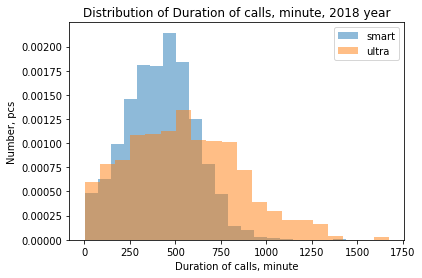

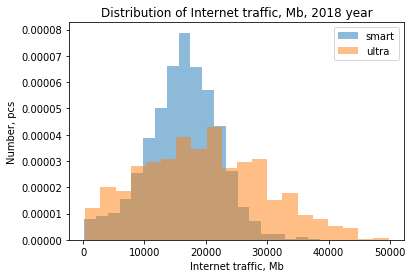

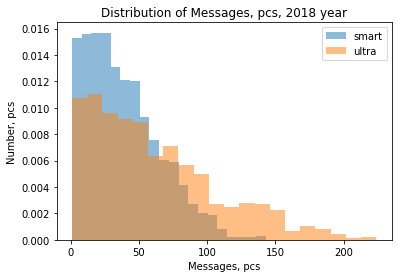

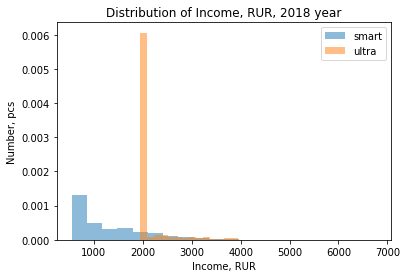

In [62]:
for col in columns:
    f, ax = plt.subplots()
    df[df['tariff'] == 'smart'][col].plot(kind='hist', bins=20, ax=ax, label='smart', alpha=0.5, density=True)
    df[df['tariff'] == 'ultra'][col].plot(kind='hist', bins=20, ax=ax, label='ultra', alpha=0.5, density=True)
    plt.legend()
    ax.set_title('Distribution of {}, 2018 year'.format(dimension.get(col)))
    ax.set_ylabel('Number, pcs')
    ax.set_xlabel('{}'.format(dimension.get(col)))

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


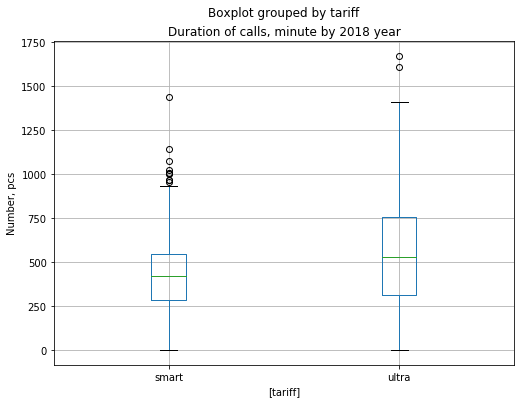

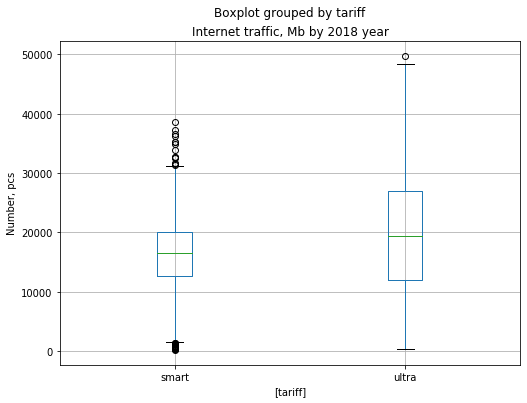

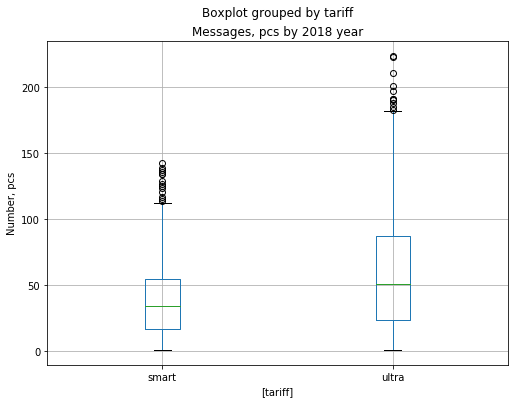

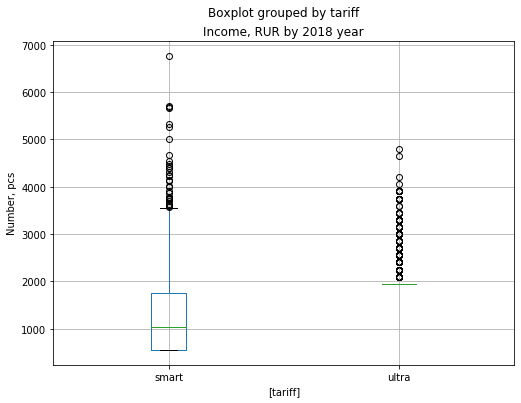

In [52]:
for col in columns:
    df.boxplot(column=col, by=['tariff'], figsize=(8,6))
    plt.title('{} by 2018 year'.format(dimension.get(col)))
    plt.ylabel('Number, pcs')
    plt.show()
    np.warnings.filterwarnings('ignore')

Если сравнивать распределения между тарифами, то они схожи по любому из анализируемых показателей, с той только разницей, что количество наблюдений по тарифу "smart" больше. Распределения звонков и интернет-траффика похожи на нормальные, с некоторыми выбросами, если судить по ящику с усами.

График распределения по сообщениям в значительной степени сосредоточен возле минимальных значений, вероятно, это можно объяснить низкой популярностью СМС сообщений после активного распространения мессенджеров.

Распределения дохода имеют пик на уровне величины абонентской платы по каждому из тарифов. Причем по тарифу "ultra" ящик с усами выродился в линию, соответствующую сумме абонентской платы - получается, что первый и третий квартиль равны между собой и равны медиане, по всей видимости большинство клиентов данного тарифа не превышают установленные лимиты и платят только абонентскую плату.

In [53]:
income_limit_smart = pd.cut((df[df['tariff'] == 'smart'])['income'],\
                            bins=[0, 550, np.inf], labels=['абонентская плата', 'больше лимита']).value_counts()
income_limit_ultra = pd.cut((df[df['tariff'] == 'ultra'])['income'],\
                            bins=[0, 1950, np.inf], labels=['абонентская плата', 'больше лимита']).value_counts()

,абонентская плата,больше лимита
smart,564,1665
ultra,851,134


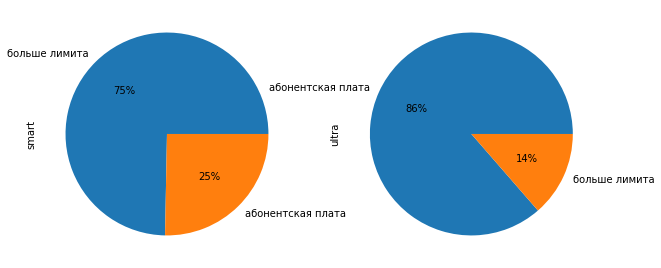

In [54]:
fig, (ax1, ax2) = plt.subplots(1,2)
income_limit_smart.plot(kind='pie', ax=ax1, autopct='%1.f%%', figsize=(10,8), label='smart')
income_limit_ultra.plot(kind='pie', ax=ax2, autopct='%1.f%%', figsize=(10,8), label='ultra')

pd.DataFrame(data = [income_limit_smart, income_limit_ultra], index=['smart', 'ultra'])

Действительно, клиентам тарифа "ultra" в подавляющем большинстве (86%) хватает предложенных тарифом минут, смс и Мб, поэтому на диаграмме размаха мы видели только единственную линию.

А вот три четверти клиентов тарифа "smart" используют дополнительные минуты, смс и Мб, но даже при этом средний доход от этих клиентов не достигает средней величины доходов от клиентов тарифа "ultra".

<a id='analysis_conclusion'></a>
## Вывод по шагу 3

70% клиентов используют тариф "smart", что отражается и на общем расходе минут/смс/интернет-траффика, а также суммарных расходах клиентов. Однако средние показатели демонстрируют противоположную картину - клиенты тарифа "ultra" и тратят больше минут/смс/мб (при этом имея бОльшую, чем по смарту, волатильность), и приносят больший средний доход, причем с меньшим разбросом значений. Вероятно, сказывается факт того, что в рамках тарифа "ultra" клиентам в большей массе достаточно заложенных минут/смс/мб (86% платежей составляет абонентская плата без доп.платежей), а в "smart" наоборот большинству этого недостаточно и происходит превышение лимита, 3/4 платжей тарифа "smart" выше абонентской платы.

Проверим статистичекую значимость обнаруженного превышения среднего уровня доходов от тарифа "ultra" над средним доходом тарифа "smart".

<a id='tests'></a>
## Шаг 4. Проверка гипотез

<a id='tests_income_tarif'></a>
### Шаг 4.1 Различия в средней выручке по тарифам

Для сопоставления данных о неравенстве средних двух совокупностей сформулируем гипотезы - нулевая гипотеза предполагает, что значения не различаются, альтернативная, напротив, утверждает, что значения различны.

H0: Средняя выручка тарифа "smart" = средней выручке тарифа "ultra"\
H1: Средняя выручка тарифа "smart" не равна средней выручке тарифа "ultra"

In [55]:
results = st.ttest_ind(df[df['tariff'] == 'smart']['income'],\
                       df[df['tariff'] == 'ultra']['income'], equal_var = False)

print('p-значение: ', results.pvalue)

p-значение:  2.7240946993530856e-246


При малом объеме выборки более вероятно получить случайный  результат, а при увеличении объема выборки случайные отклонения компенсируют друг друга, и получить значимое различие в выборках при их однородности менее вероятно. Учитывая, что объем выборки по тарифу "smart" составляет 2229, а по тарифу "ultra" - 985, выберем для проведения статистического анализа меньший, чем стандартный, уровень значимости. Определим уровень значимости в размере 1%. 

In [56]:
alpha = .01
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что с очень малой вероятностью, стремящейся к 0, найденное различие средних доходов можно получить случайно, таким образом, выбранный критерий значимости не был превышен, можем отвергнуть нулевую гипотезу и сделать вывод о значимом различии между средними выручками от разных тарифов по данным выборки.

Проведем односторонний тест и проверим гипотезу превышения средней выручки по тарифу "ultra" над выручкой тарифа "smart". Нулевая гипотеза снова предполагает, что они одинаковы, альтернативная  - что  выручка тарифа "ultra" > 1294.64 RUR

H0: Средняя выручка тарифа "smart" = средней выручке тарифа "ultra"\
H1: Средняя выручка тарифа "smart" меньше средней выручки тарифа "ultra"

In [57]:
smart_mean = df[df['tariff'] == 'smart']['income'].mean()
results = st.ttest_1samp(df[df['tariff'] == 'ultra']['income'], smart_mean)

if (results.pvalue / 2 < alpha) and (df[df['tariff'] == 'ultra']['income'].mean() > smart_mean):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


Гипотеза о равенстве выручек снова была отвергнута, данные выборки не противоречат гипотезе о превышении выручки тарифа "ultra" над выручкой тарифа "smart"

<a id='tests_income_location'></a>
### Шаг 4.2 Различия в средней выручке по регионам

H0: Средняя выручка по Москве = средней выручке по другим регионам\
H1: Средняя выручка по Москве не равна средней выручке по другим регионам

In [58]:
results = st.ttest_ind(df[df['city'] == 'Москва']['income'],\
                       df[df['city'] != 'Москва']['income'])

print('p-значение: ', results.pvalue)

p-значение:  0.531666503831252


In [59]:
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


Полученные по выборке данные о средних выручках по регионам не противоречат нулевой гипотезе, с учетом выбранного критерия значимости разница в средних выручках по Москве и в регионах статистически не была подтверждена.

<a id='tests_conclusion'></a>
## Вывод по шагу 4

Для выбранного критерия значимости на уровне 1% проведенный тест позволил отбросить нулевую гипотезу и сделать вывод о значимом различии между средними выручками от разных тарифов по данным выборки. Односторонний тест показал, что данные выборки не противоречат гипотезе о превышении выручки тарифа "ultra" над выручкой тарифа "smart".

А вот данные по выручке в зависимости от региона не получили статистического подтверждения с учетом выбранного уровня значимости, нулевая гипотеза не была отвергнута.

<a id='total_conclusion'></a>
## Шаг 5. Общий вывод

Большинство клиентов выбирают тариф "smart" (70% анализируемой выборки), при этом в среднем тратят меньше минут разговора, сообщений и объема интернет-трафика, чем на тарифе "ultra". 

Среднее значение дохода, которое приносит тариф "smart" (1295 руб. в месяц на 1 клиента), также ниже аналогичного показателя тарифа "ultra" (2071 руб.), причем последний отличается еще и меньшим разбросом значений. Проведенные статистические тесты с уровнем значимости в 1% говорят о том, что данные выборки не противоречат гипотезе о превышении средней выручки от одного клиента с тарифом "ultra" над средней выручкой от тарифа "smart". Вероятно, в рамках тарифа "ultra" клиентам в большей массе достаточно заложенных минут/смс/мб (86% платежей составляет абонентская плата без доп.платежей), а в "smart" наоборот большинству этого недостаточно и происходит превышение лимита, 3/4 платжей тарифа "smart" выше абонентской платы.

Но несмотря на то, что в рамках тарифа "ultra" клиенты за редким исключением перерасходуют предложенные лимиты, размер абонентской платы по данному тарифу выше, чем граница третьего квартиля по средней выручке клиентов тарифа "smart". Поэтому с точки зрения уровня возможного дохода привлекательней для продвижения выглядит тариф "ultra" вне зависимости от региона продвижения.